In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import os
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

from fr_models import analytic_models as amd
from fr_models import optimize as optim
from fr_models import gridtools
from fr_models import constraints as con
import utils

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
grid = gridtools.Grid([1.0,1.0],(5,5),device=device)
print(grid.dA)
print(grid.tensor.shape)
grid = grid.to('cpu')
print(grid.dA)
grid = grid.to(device).cpu()
print(grid.dA)

0.0625
torch.Size([5, 5, 2])
0.0625
0.0625


In [30]:
try:
    try:
        assert 1 == 0, 'underflow in dt 1.023'
    except AssertionError as err:
        # raise
        if str(err).startswith('underflow in dt'):
            raise ValueError("HI")
except ValueError as err:
    print(err)

HI


In [11]:
def get_dirs(path):
    dirs = []
    path = pathlib.Path(path)
    for dir_name in os.listdir(path):
        full_path = path / dir_name
        if os.path.isdir(full_path) and dir_name != '.ipynb_checkpoints':
            dirs.append(full_path)
    return np.array(dirs)

In [123]:
values = torch.load('/home/hc3190/ken/fr-models/test/data/problem_tensors/values.pt')
as_s_0 = torch.load('/home/hc3190/ken/fr-models/test/data/problem_tensors/as_s_0.pt')
as_s_1 = torch.load('/home/hc3190/ken/fr-models/test/data/problem_tensors/as_s_1.pt')
as_s = [as_s_0, as_s_1]
print(values, as_s)
print(values.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0') [tensor([26, 28, 30, 32, 34, 36, 39, 41, 43, 45, 47, 49], device='cuda:0'), tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24], device='cuda:0')]
torch.Size([51, 51])


/home/hc3190/ken/fr-models/test/data/trained_models/b20bd5a1-6e0b-4cf2-ac1a-71f0af71b5d4
Loss: 0.5500981211662292
0.41427081823349
0.25515663623809814
{'training': True, '_parameters': OrderedDict([('W', Parameter containing:
tensor([[ 0.6782, -1.6414, -0.4041,  0.0000],
        [ 1.7539, -3.2668, -2.6299,  0.0000],
        [ 0.3717,  0.0000,  0.0000, -0.3613],
        [ 0.8506, -0.9220, -0.7956,  0.0000]], device='cuda:0',
       requires_grad=True)), ('sigma_s', Parameter containing:
tensor([[0.1000, 0.1000, 0.4993, 0.1736],
        [0.1000, 0.1073, 0.1077, 0.2436],
        [0.1380, 0.4708, 0.1950, 0.1488],
        [0.1004, 0.1353, 0.4398, 0.1281]], device='cuda:0', requires_grad=True))]), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': Order

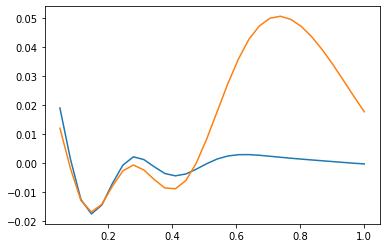

In [65]:
import pprint
import logging
import uuid
import pathlib

import torch
import numpy as np

from fr_models import analytic_models as amd
from fr_models import response_models as rmd
from fr_models import optimize as optim
from fr_models import gridtools, criteria, regularizers
from fr_models import constraints as con
import utils

logger = logging.getLogger(__name__)

def load_exp_data(filepath, x_cutoff=300.0, symmetric=False, normalize=0.5):
    data = np.loadtxt(filepath, delimiter=',')
    x_data, y_data, y_data_sem = data[0], data[1], data[2]
    length = np.sum(x_data < x_cutoff)
    if symmetric:
        length = length - 1 if length % 2 == 0 else length
    x_data, y_data, y_data_sem = x_data[:length], y_data[:length], y_data_sem[:length]
    if normalize is not None:
        scale = np.max(x_data)/normalize
        x_data = x_data/scale
    else:
        scale = 1.0
    return x_data.reshape(-1,1), y_data, y_data_sem, scale
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define length scale for model data
L = 1.0

# Define parameters and model
b = optim.Bounds(epsilon=1.0e-8)

# W
w_dist = torch.distributions.Normal(0.0,1.0)
W = optim.Parameter(
    # torch.tensor([
    #     [w_dist.sample().abs(), -w_dist.sample().abs()],
    #     [w_dist.sample().abs(), -w_dist.sample().abs()],
    # ]),
    torch.tensor([
        [0.79903045, -0.22798239],
        [0.78063547, -0.01],
    ]),
    bounds=torch.tensor([
        [b.pos, b.neg],
        [b.pos, b.neg],
    ]),
    requires_optim=True,
)

# sigma
sigma_bounds = [0.01,0.5]
s_dist = torch.distributions.Uniform(*sigma_bounds)
sigma_s = optim.Parameter(
    # s_dist.sample((2,2)),
    torch.tensor(
        [[30.60939689, 31.54267749],
         [ 5.82356181, 11.72982061]]
    )/575.0,      
    bounds=torch.tensor(sigma_bounds),
)
ndim_s = 1 # 2 spatial dimensions

# amplitude
a_dist = torch.distributions.Normal(0.0,1.0)
amplitude = optim.Parameter(
    # a_dist.sample().abs(),
    torch.tensor(1.5973258580974314),
    bounds=torch.tensor(b.pos),
)

Ls = [2*L]*ndim_s # we want our model to be twice as long as actual data
shape = tuple([101]*ndim_s)
w_dims = []

a_model = amd.SpatialSSNModel(W, sigma_s, ndim_s, w_dims=w_dims)
grid = gridtools.Grid(Ls, shape, w_dims=w_dims, device=device)
_, y_data_base, _, _ = load_exp_data('/home/hc3190/ken/spatial-model/data/baselines_new/base_by_dist.txt', normalize=L/2)
r_star = torch.tensor([np.mean(y_data_base), 1.2*np.mean(y_data_base)], dtype=torch.float)
r_star = optim.Parameter(r_star, requires_optim=False)

solver_kwargs = None
model = rmd.SteadyStateResponse(
    a_model, 
    grid, 
    r_star, 
    amplitude, 
    torch.tensor(0), 
    torch.tensor(0), 
    dr_rtol=1.0e-4, 
    dr_atol=1.0e-6, 
    max_t=500.0, 
    solver_kwargs=solver_kwargs
)

for dirname in get_dirs('/home/hc3190/ken/fr-models/test/data/trained_models'):
    # if not any([str(dirname.parts[-1]).startswith(prefix) for prefix in ['b20bd','066703']]):
        # continue
    print(dirname)
    state_dict = torch.load(f'{dirname}/state_dict.pth.tar')
    loss = utils.io.load_config(f'{dirname}/meta.json')['loss']
    model.load_state_dict(state_dict)
    model.to(device)

    model.dr_rtol = 1.0e-3
    model.dr_atol = 1.0e-5
    x = torch.linspace(0.05,1.0,steps=30,device=device)[:,np.newaxis]
    y = model(x)
    plt.plot(x.squeeze().detach().cpu().numpy(), y.detach().cpu().numpy())

    print(f"Loss: {loss}")
    
    constraints = [
        # con.SpectralRadiusCon(max_spectral_radius=0.99, trials=1),
        con.StabilityCon(max_instability=0.99, trials=1),
        con.ParadoxicalCon(cell_type=1, min_subcircuit_instability=1.01, trials=1),
    ]
    
    # for constraint in constraints:
    #     print(constraint(model))
    # print(model.a_model.__dict__)

Parameter containing:
tensor([[ 0.7990, -0.2280],
        [ 0.7806, -0.0100]], requires_grad=True)
Parameter containing:
tensor([[0.0532, 0.0549],
        [0.0101, 0.0204]], requires_grad=True)
[2.0]
(101,)
[]
Parameter containing:
tensor([0.7214, 0.8657])
Loss: 0.9910950064659119
0.32074212074279784
0.3452680015563965


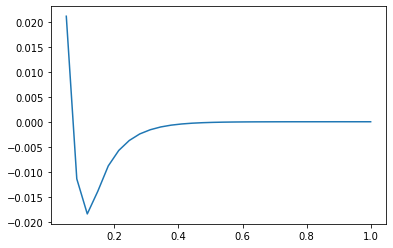

In [46]:
import pprint
import logging
import uuid

import torch
import numpy as np

from fr_models import analytic_models as amd
from fr_models import response_models as rmd
from fr_models import optimize as optim
from fr_models import gridtools, criteria, regularizers
from fr_models import constraints as con

def load_exp_data(filepath, x_cutoff=300.0, symmetric=False, normalize=0.5):
    data = np.loadtxt(filepath, delimiter=',')
    x_data, y_data, y_data_sem = data[0], data[1], data[2]
    length = np.sum(x_data < x_cutoff)
    if symmetric:
        length = length - 1 if length % 2 == 0 else length
    x_data, y_data, y_data_sem = x_data[:length], y_data[:length], y_data_sem[:length]
    if normalize is not None:
        scale = np.max(x_data)/normalize
        x_data = x_data/scale
    else:
        scale = 1.0
    return x_data.reshape(-1,1), y_data, y_data_sem, scale
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define length scale for space
L = 1.0

# Define parameters and model
b = optim.Bounds(epsilon=1.0e-8)

# W
w_dist = torch.distributions.Normal(0.0,1.0)
W = optim.Parameter(
    torch.tensor([
        [0.79903045, -0.22798239],
        [0.78063547, -0.01],
    ]),
    bounds=torch.tensor([
        [b.pos, b.neg],
        [b.pos, b.neg],
    ]),
)

# sigma
sigma_bounds = [0.01,0.5]
s_dist = torch.distributions.Uniform(*sigma_bounds)
sigma_s = optim.Parameter(
    torch.tensor(
        [[30.60939689, 31.54267749],
         [ 5.82356181, 11.72982061]]
    )/575.0,
    bounds=torch.tensor(sigma_bounds),
)
ndim_s = 1 # 2 spatial dimensions

# amplitude
a_dist = torch.distributions.Normal(0.0,1.0)
amplitude = optim.Parameter(
    torch.tensor(1.5973258580974314),
    bounds=torch.tensor(b.pos),
)

Ls = [2*L]*ndim_s
shape = tuple([101]*ndim_s)
w_dims = []

print(W)
print(sigma_s)
print(Ls)
print(shape)
print(w_dims)
a_model = amd.SpatialSSNModel(W, sigma_s, ndim_s, w_dims=w_dims)
grid = gridtools.Grid(Ls, shape, w_dims=w_dims, device=device)
_, y_data_base, _, _ = load_exp_data('/home/hc3190/ken/spatial-model/data/baselines_new/base_by_dist.txt', normalize=L/2)
r_star = torch.tensor([np.mean(y_data_base), 1.2*np.mean(y_data_base)], dtype=torch.float)
r_star = optim.Parameter(r_star, requires_optim=False)
print(r_star)
solver_kwargs = None
model = rmd.SteadyStateResponse(
    a_model, 
    grid, 
    r_star, 
    amplitude, 
    torch.tensor(0), 
    torch.tensor(0), 
    dr_rtol=1.0e-4, 
    dr_atol=1.0e-6, 
    max_t=500.0, 
    solver_kwargs=solver_kwargs
)


model.to(device)

x = torch.linspace(0.05,1.0,steps=30,device=device)[:,np.newaxis]
y = model(x)
plt.plot(x.squeeze().detach().cpu().numpy(), y.detach().cpu().numpy())

print(f"Loss: {loss}")

constraints = [
    # con.SpectralRadiusCon(max_spectral_radius=0.99, trials=1),
    con.StabilityCon(max_instability=0.99, trials=1),
    con.ParadoxicalCon(cell_type=1, min_subcircuit_instability=1.01, trials=1),
]

for constraint in constraints:
    print(constraint(model))
# print(model.__dict__)

/tmp/ipykernel_216091/2714560908.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(W_pop, dtype=torch.float, device=device)
/tmp/ipykernel_216091/2714560908.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(sigma_pop, dtype=torch.float, device=device)
/tmp/ipykernel_216091/2714560908.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  r_star = torch.tensor(r_star, dtype=torch.float, device=device)
/tmp/ipykernel_216091/2714560908.py:91: UserWarning: To copy construct from a tensor, it is recomm

[ 0.05631642  0.00323676 -0.01835608 -0.01322922 -0.00728601 -0.00411066
 -0.00233813 -0.00133206 -0.00075507 -0.00042826 -0.00024205 -0.00013715]
tensor(0.2029)


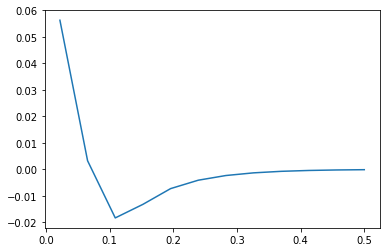

In [50]:
def get_data(path):
    data = utils.io.load_data(path)
    
    popt = data['popt']
    fit_options = data['meta']['fit_options']
    w_dims = data['meta']['w_dims']
    Ls = fit_options['Ls']
    shape = fit_options['shape']
    if 'r_star' in fit_options:
        r_star = fit_options['r_star']
    else:
        r_star = np.copy(popt['r_star'])
    
    x_data = data['x_data']
    y_data = data['y_data']
    new_y_data = data['new_y_data']
    x_scale = data['x_scale']
    
    W_pop, sigma_pop, amplitude = np.copy(popt['W_pop']), np.copy(popt['sigma_pop']), np.copy(popt['amplitude'])
    
    return (W_pop, sigma_pop, amplitude, r_star, Ls, shape, w_dims), (x_data, y_data, new_y_data, x_scale)


def get_xy(acts, plot_dim, Ls, w_dims=[], marg_dims=[], half=True, offset=1, x_scale=1.0):
    shape = acts.shape
    D = len(shape)
    
    mids = gridtools.get_mids(shape, w_dims=w_dims)
    if isinstance(offset, int):
        offset = [offset if d == plot_dim else 0 for d in range(D)]
    locs = [mids[i] + offset[i] for i in range(len(mids))]
    endpoint = False if plot_dim in w_dims else True
    
    start = offset[plot_dim]
    if half:
        start += mids[plot_dim]
    
    x = np.linspace(-Ls[plot_dim]/2,Ls[plot_dim]/2,shape[plot_dim],endpoint=endpoint)
    indices = tuple(locs[:plot_dim]+[slice(None)]+locs[plot_dim+1:])
    y = acts[indices]
    
    if plot_dim in w_dims:
        x = np.append(x, -x[:1])
        y = np.append(y, y[:1])
        
    return x[start:]*x_scale, y[start:]

# def get_interpolated_response(plot_dim

plot_dim = 0
i, j = 0, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

W_pop = torch.tensor([
    [0.79903045, -0.22798239],
    [0.78063547, -0.01],
])
sigma_pop = torch.tensor(
    [[30.60939689, 31.54267749],
     [ 5.82356181, 11.72982061]]
)/575.0
amplitude = torch.tensor(1.5973258580974314)
r_star = torch.tensor([0.72140299, 0.86568359])
Ls = [2.0]
shape = (101,)
w_dims = []
x_data = torch.tensor([[0.02173913],
       [0.06521739],
       [0.10869565],
       [0.15217391],
       [0.19565217],
       [0.23913043],
       [0.2826087 ],
       [0.32608696],
       [0.36956522],
       [0.41304348],
       [0.45652174],
       [0.5       ]])
y_data = torch.tensor([ 0.03384634, -0.00100905, -0.01046895, -0.01714387, -0.00874027,
       -0.00241034, -0.00310725, -0.00151445,  0.00084196,  0.00734536,
       -0.00242054, -0.00058409])
new_y_data = torch.tensor([ 0.05707308,  0.00041438, -0.01248258, -0.01754514, -0.01006825,
       -0.0031974 , -0.00321406,  0.00150142, -0.00175786,  0.00171163,
       -0.00200328,  0.00846514])

W = torch.tensor(W_pop, dtype=torch.float, device=device)
sigma = torch.tensor(sigma_pop, dtype=torch.float, device=device)
a_model = amd.SpatialSSNModel(W, sigma, 1, w_dims=w_dims)
grid = gridtools.Grid(Ls, shape, w_dims=w_dims, device=device)
r_star = torch.tensor(r_star, dtype=torch.float, device=device)
amplitude = torch.tensor(amplitude, dtype=torch.float, device=device)

torch_x_data = torch.tensor(x_data, dtype=torch.float, device=device)
# torch_x_data = torch.linspace(0.05,1.0,steps=30,device=device)[:,np.newaxis]
# x_data = torch_x_data.cpu().numpy()

# print(x_data)
# print(torch_x_data)
# print(y_data)

# solver_kwargs = {'method': 'dopri5', 'rtol': 1.0e-3, 'atol': 1.0e-5, 'max_t': 10000.0}
solver_kwargs = None
model = rmd.SteadyStateResponse(a_model, grid, r_star, amplitude, torch.tensor(0), torch.tensor(0), solver_kwargs=solver_kwargs)
model.to(device)

E_y = model(torch_x_data).cpu().numpy()
print(E_y)
print(criteria.NormalizedLoss()(torch.tensor(E_y, dtype=torch.float), new_y_data))

model = rmd.SteadyStateResponse(a_model, grid, r_star, amplitude, torch.tensor(1), torch.tensor(0), solver_kwargs=solver_kwargs)
model.to(device)

I_y = model(torch_x_data).cpu().numpy()

plt.plot(x_data, E_y)
# plt.plot(x_data, I_y)
plt.show()

In [57]:
x_data, y_data_mean, y_data_sem, scale = load_exp_data('/home/hc3190/ken/spatial-model/data/space_resp/resp_geq500_min.txt', normalize=L/2)
print(scale)

575.0


/home/hc3190/ken/V1-perturb/test/data/responses/4084cb45-eedb-4674-a074-d5f9c081656f.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


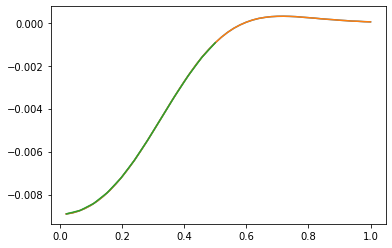

/home/hc3190/ken/V1-perturb/test/data/responses/0fb995d9-6f45-4533-a7e9-348fdd897ef0.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


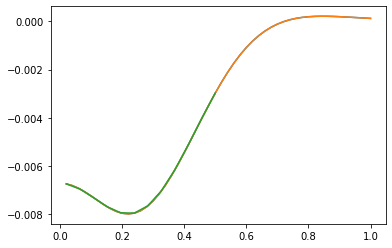

/home/hc3190/ken/V1-perturb/test/data/responses/2916b5df-64e1-4039-b05a-d5ec961e2550.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


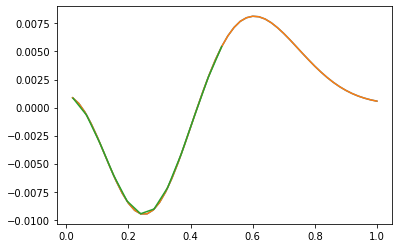

/home/hc3190/ken/V1-perturb/test/data/responses/645a6fe4-6cac-4deb-9eb6-40abebf9a581.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


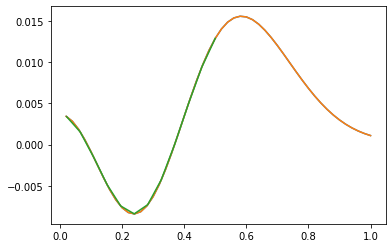

/home/hc3190/ken/V1-perturb/test/data/responses/33581294-e6bf-4136-86ef-acbd0d0397bf.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


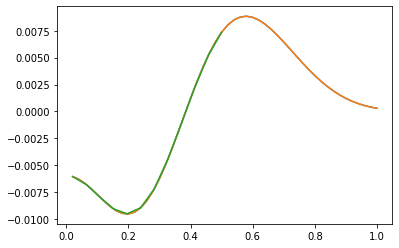

/home/hc3190/ken/V1-perturb/test/data/responses/8cc19e2d-2e36-4056-a340-bdea0f2a0be2.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


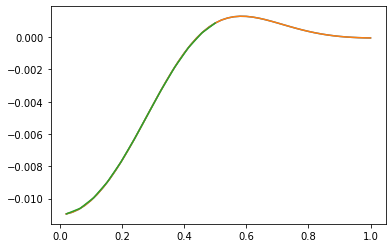

/home/hc3190/ken/V1-perturb/test/data/responses/a8d04942-8991-44de-8873-3bb73dac1483.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


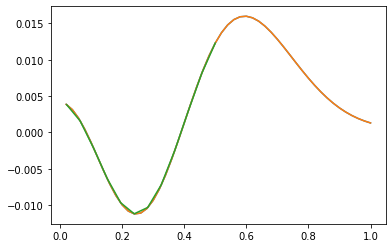

/home/hc3190/ken/V1-perturb/test/data/responses/0ce993d0-81ba-466a-b3f8-678c451f7d72.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


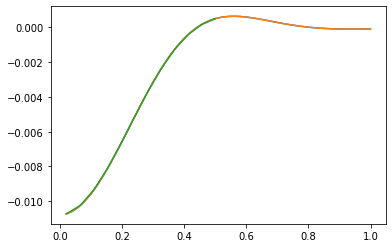

/home/hc3190/ken/V1-perturb/test/data/responses/40ec6b7d-57f3-413a-88e3-241b96f8e882.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


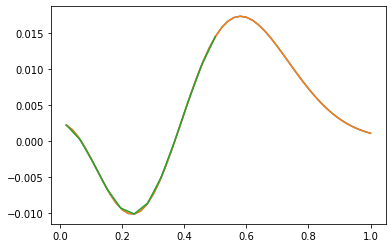

/home/hc3190/ken/V1-perturb/test/data/responses/a09139dd-3ccf-40de-b2e8-82dbd3eae684.pkl
[[0.02173913]
 [0.06521739]
 [0.10869565]
 [0.15217391]
 [0.19565217]
 [0.23913043]
 [0.2826087 ]
 [0.32608696]
 [0.36956522]
 [0.41304348]
 [0.45652174]
 [0.5       ]]
tensor([[0.0217],
        [0.0652],
        [0.1087],
        [0.1522],
        [0.1957],
        [0.2391],
        [0.2826],
        [0.3261],
        [0.3696],
        [0.4130],
        [0.4565],
        [0.5000]], device='cuda:0')
[ 0.03384634 -0.00100905 -0.01046895 -0.01714387 -0.00874027 -0.00241034
 -0.00310725 -0.00151445  0.00084196  0.00734536 -0.00242054 -0.00058409]


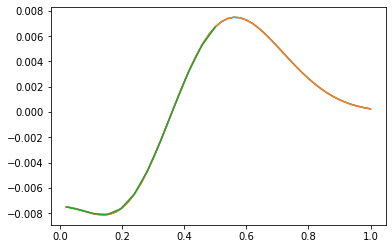

/home/hc3190/ken/V1-perturb/test/data/responses/4084cb45-eedb-4674-a074-d5f9c081656f.pkl
tensor(12.3033, device='cuda:0')


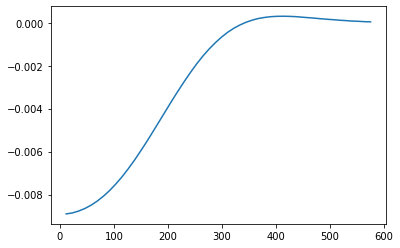

/home/hc3190/ken/V1-perturb/test/data/responses/0fb995d9-6f45-4533-a7e9-348fdd897ef0.pkl
tensor(16.9347, device='cuda:0')


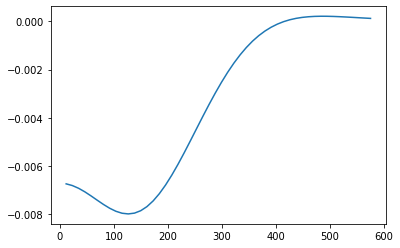

/home/hc3190/ken/V1-perturb/test/data/responses/2916b5df-64e1-4039-b05a-d5ec961e2550.pkl
tensor(188.6044, device='cuda:0')


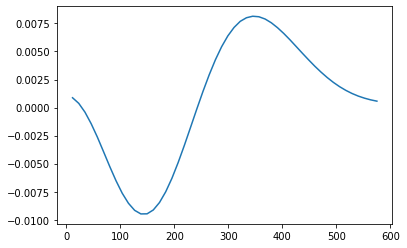

/home/hc3190/ken/V1-perturb/test/data/responses/645a6fe4-6cac-4deb-9eb6-40abebf9a581.pkl
tensor(16.0594, device='cuda:0')


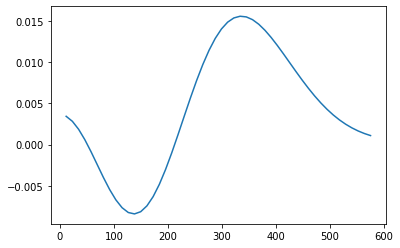

/home/hc3190/ken/V1-perturb/test/data/responses/33581294-e6bf-4136-86ef-acbd0d0397bf.pkl
tensor(14.3366, device='cuda:0')


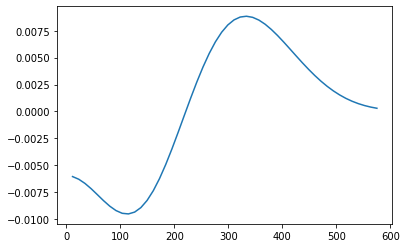

/home/hc3190/ken/V1-perturb/test/data/responses/8cc19e2d-2e36-4056-a340-bdea0f2a0be2.pkl
tensor(11.9623, device='cuda:0')


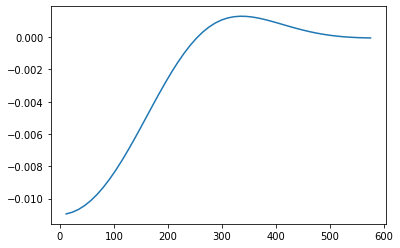

/home/hc3190/ken/V1-perturb/test/data/responses/a8d04942-8991-44de-8873-3bb73dac1483.pkl
tensor(18.2173, device='cuda:0')


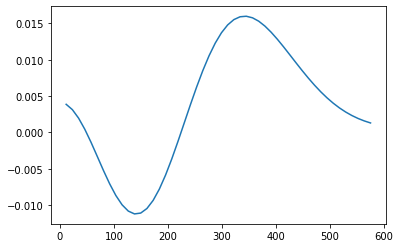

/home/hc3190/ken/V1-perturb/test/data/responses/0ce993d0-81ba-466a-b3f8-678c451f7d72.pkl
tensor(10.6031, device='cuda:0')


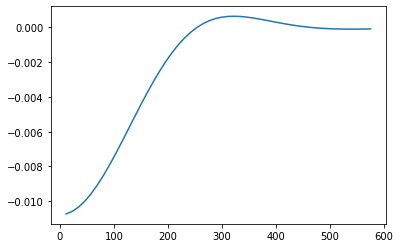

/home/hc3190/ken/V1-perturb/test/data/responses/40ec6b7d-57f3-413a-88e3-241b96f8e882.pkl
tensor(18.0288, device='cuda:0')


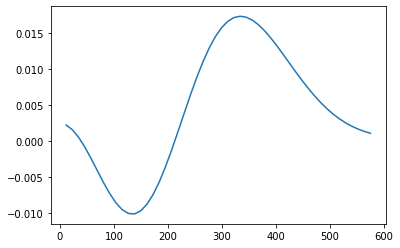

/home/hc3190/ken/V1-perturb/test/data/responses/a09139dd-3ccf-40de-b2e8-82dbd3eae684.pkl
tensor(13.8828, device='cuda:0')


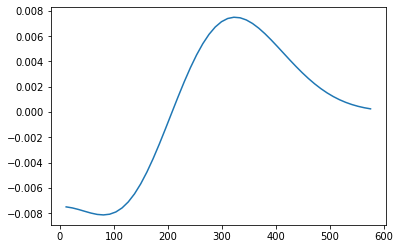

In [213]:
def get_data(path):
    data = utils.io.load_data(path)
    
    popt = data['popt']
    fit_options = data['meta']['fit_options']
    w_dims = data['meta']['w_dims']
    Ls = fit_options['Ls']
    shape = fit_options['shape']
    if 'r_star' in fit_options:
        r_star = fit_options['r_star']
    else:
        r_star = np.copy(popt['r_star'])
    
    x_data = data['x_data']
    y_data = data['y_data']
    new_y_data = data['new_y_data']
    x_scale = data['x_scale']
    
    W_pop, sigma_pop, amplitude = np.copy(popt['W_pop']), np.copy(popt['sigma_pop']), np.copy(popt['amplitude'])
    
    return (W_pop, sigma_pop, amplitude, r_star, Ls, shape, w_dims), (x_data, y_data, new_y_data, x_scale)


def get_xy(acts, plot_dim, Ls, w_dims=[], marg_dims=[], half=True, offset=1, x_scale=1.0):
    shape = acts.shape
    D = len(shape)
    
    mids = gridtools.get_mids(shape, w_dims=w_dims)
    if isinstance(offset, int):
        offset = [offset if d == plot_dim else 0 for d in range(D)]
    locs = [mids[i] + offset[i] for i in range(len(mids))]
    endpoint = False if plot_dim in w_dims else True
    
    start = offset[plot_dim]
    if half:
        start += mids[plot_dim]
    
    x = np.linspace(-Ls[plot_dim]/2,Ls[plot_dim]/2,shape[plot_dim],endpoint=endpoint)
    indices = tuple(locs[:plot_dim]+[slice(None)]+locs[plot_dim+1:])
    y = acts[indices]
    
    if plot_dim in w_dims:
        x = np.append(x, -x[:1])
        y = np.append(y, y[:1])
        
    return x[start:]*x_scale, y[start:]

# def get_interpolated_response(plot_dim

plot_dim = 0
i, j = 0, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = pathlib.Path('/home/hc3190/ken/V1-perturb/test/data/responses')
for filename in data_path.glob('*.pkl'):
    print(filename)
    data = utils.io.load_data(filename)

    model_data, exp_data = get_data(data['path'])
    W_pop, sigma_pop, amplitude, r_star, Ls, shape, w_dims = model_data
    x_data, y_data, new_y_data, x_scale = exp_data

    W = torch.tensor(W_pop, dtype=torch.float, device=device)
    sigma = torch.tensor(sigma_pop, dtype=torch.float, device=device)
    a_model = amd.GaussianSSNModel(W, sigma, w_dims=w_dims)
    grid = gridtools.Grid(Ls, shape, w_dims=w_dims, device=device)
    r_star = torch.tensor(r_star, dtype=torch.float, device=device)
    amplitude = torch.tensor(amplitude, dtype=torch.float, device=device)

    torch_x_data = torch.tensor(x_data, dtype=torch.float, device=device)

    print(x_data)
    print(torch_x_data)
    print(y_data)

    # solver_kwargs = {'method': 'dopri5', 'rtol': 1.0e-3, 'atol': 1.0e-5, 'max_t': 10000.0}
    solver_kwargs = None
    model = rmd.SteadyStateResponse(a_model, grid, r_star, amplitude, torch.tensor(0), torch.tensor(0), solver_kwargs=solver_kwargs)
    model.to(device)

    E_y = model(torch_x_data).cpu().numpy()

    model = rmd.SteadyStateResponse(a_model, grid, r_star, amplitude, torch.tensor(1), torch.tensor(0), solver_kwargs=solver_kwargs)
    model.to(device)

    I_y = model(torch_x_data).cpu().numpy()
    
    plt.plot(x_data, E_y)
    # plt.plot(x_data, I_y)
    plt.show()
    
plot_dim = 0
i, j = 0, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = pathlib.Path('/home/hc3190/ken/V1-perturb/test/data/responses')
for filename in data_path.glob('*.pkl'):
    print(filename)
    data = utils.io.load_data(filename)

    model_data, exp_data = get_data(data['path'])
    W_pop, sigma_pop, amplitude, r_star, Ls, shape, w_dims = model_data
    x_data, y_data, new_y_data, x_scale = exp_data

    W = torch.tensor(W_pop, dtype=torch.float, device=device)
    sigma = torch.tensor(sigma_pop, dtype=torch.float, device=device)
    r_star = torch.tensor(r_star, dtype=torch.float, device=device)
    amplitude = torch.tensor(amplitude, dtype=torch.float, device=device)

    grid = gridtools.Grid(Ls, shape, w_dims=w_dims, device=device)
    a_model = amd.GaussianSSNModel(W, sigma, w_dims=w_dims)
    n_model = a_model.numerical_model(grid).nonlinear_perturbed_model(r_star)
    n_model.to(device)

    delta_h = n_model.get_h(amplitude, torch.tensor(j, device=device))
    delta_r0 = torch.tensor(0.0, device=device)
    # t = torch.tensor(500.0, device=device)
    # delta_r, _ = n_model(delta_h, delta_r0, t)
    t0 = torch.tensor(0.0, device=device)
    delta_r, t = n_model.steady_state(delta_h, delta_r0, t0, method='dopri5')
    print(t)
    delta_r = delta_r.detach().cpu().numpy()

    E_x, E_y = get_xy(delta_r[0], plot_dim, Ls, w_dims=w_dims, x_scale=x_scale, offset=1)
    
    plt.plot(E_x, E_y)
    # plt.plot(x_data, I_y)
    plt.show()

In [142]:
hi = torch.tensor(0.0, device=device)
print(hi == 0)

tensor(True, device='cuda:0')


In [113]:
indices = [
    torch.tensor([26, 28, 30, 32, 34, 36, 39, 41, 43, 45, 47, 49], device='cuda:0'),
    torch.tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24], device='cuda:0')
]
print(values[indices])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [104]:
hi = torch.arange(25).reshape(5,5)
indices = [torch.arange(3), torch.arange(3)]
print(hi)
print(hi[indices])

tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]])
tensor([ 0,  6, 12])


In [128]:
# class TestMultiCellSSNModel:
#     def test_W(self):
model_name = 'model_1'
model_config = utils.io.load_data(f'data/{model_name}/a_model_config.pkl')
model_W = utils.io.load_data(f'data/{model_name}/n_model_W.pkl')
W = torch.tensor(model_config['W'])
sigma = torch.tensor(model_config['sigma'])
a_model = amd.GaussianSSNModel(W, sigma, w_dims=model_config['w_dims'], wn_order=11, period=model_config['Ls'])
n_model = a_model.numerical_model(model_config['Ls'], model_config['shape'], device=device)
n_model_W = n_model.W.cpu().detach().numpy()

{'W': array([[ 0.12, -0.4 ],
       [ 0.31, -0.4 ]]), 'sigma': array([[[1.2  ],
        [0.384]],

       [[0.396],
        [0.526]]]), 'r_star': array([0.5, 0.6]), 'Ls': [6.283185307179586], 'shape': (100,), 'w_dims': [0], 'wn_order': 11}


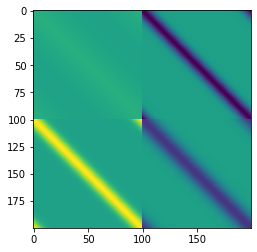

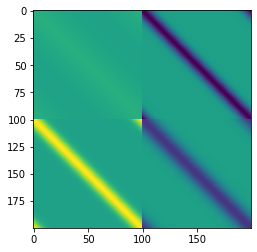

In [118]:
plt.imshow(model_W)
plt.show()
plt.imshow(n_model_W)
plt.show()

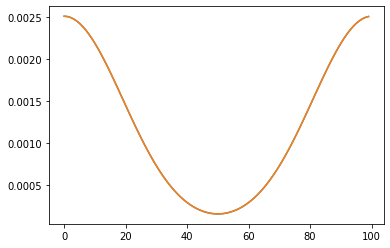

In [127]:
plt.plot(model_W.reshape(2,100,2,100)[0,0,0])
plt.plot(n_model_W.reshape(2,100,2,100)[0,0,0])
plt.show()

In [108]:
print(model_W.reshape(2,100,2,100)[0,0,0])
print(n_model_W.reshape(2,100,2,100)[0,0,0])

0.005703555049828647
0.0057035551281550195


In [55]:
s = 0.5
w = 0.12
dA = 6.0/100
expected = 1/(2*torch.pi*s**2)**0.5*w*np.sum([np.exp(-0.5*(2*np.pi*i)**2/s**2)for i in range(-5,6)])*dA
print(expected)

0.00574476883778063


In [67]:
0.0041/0.06

0.06833333333333334

In [72]:
print(1/(2*torch.pi*s**2)**0.5)

0.7978845608028654


In [133]:
hi = (1,2,3)
hi = torch.tensor(hi)
print(hi.shape)
hi = torch.atleast_2d(hi)
print(hi.shape)

torch.Size([3])
torch.Size([1, 3])
